# Traffic stops at Rhode Island

## Table of contents
1. [Introduction](#introduction)
2. [Data cleaning](#cleaning)
    1. [Removing missing data](#missing)
    2. [Using proper datatypes](#converting)
3. [Exploratory data analysis (EDA)](#eda)
    1. [Studies by gender](#gender)
        1. [Reason for stop](#reason)
        2. [Speeding outcome](#outcome)
        3. [Search rate](#search_rate)
    2. [Studies over time](#time)
        1. [Arrest per daytime](#arrests_day)
        2. [Search rate by year](#search_year)
        3. [Search rate by weekday](#search_weekday)
        4. [Search versus arrest rates](#search_arrest_decrease)
    3. [Reason for stop by district](#violations_district)
4. [Adding weather data](#weather)
    1. [Counting bad weather conditions](#bad_weather)
    2. [Preparing the two dataframes to be merged](#prepare_merge)
    3. [Comparing arrest rates by weather rating](#arrest_rating)


## Introduction <a name="introduction"></a>

This project uses data from ["The Stanford open policing project"](https://openpolicing.stanford.edu/) to analyse traffic stops by police officers in the Rhode Island State of the United States. After cleaning the data, several questions are answered by analysing it and by using visualisation tools. In particular, we are interested in analysing the impact of gender and race on the police behaviour. 

In addition, we combine this dataset with weather information from the ["National Centers for Environmental Information"](https://www.ncei.noaa.gov/) in order to understand how the weather conditions impact the police behaviour.



In [1]:
import pandas as pd

# Read input data and create a dataframe
input_file = 'data/ri_statewide_2020_04_01.csv'

ri = pd.read_csv(input_file, low_memory=False) #low_memory=False turns down a warning about some columns having mixed datatypes. This will be fixed later.



## Data cleaning <a name="cleaning"></a>

The first objective is to get the data ready to be analysed. We start by dropping columns with a large fraction of missing data as well as columns that have only 1 unique value. Rows with a significant fraction of missing data will be dropped as well. The acceptable thresholds for missing data will be decided after inspecting the dataset. 

Next, we look at the datatypes to check wether there is any column that would be more appropriate to be stored with a different dataype. For example, it is common that some of the columns that should be booleans or integers are stored as strings. This makes it easier to process the data in later steps. 

### Removing missing data <a name="missing"></a>

In [2]:
# Number of rows and columns
print(ri.shape)

(509681, 31)


In [3]:
# % of missing data in each column
print(100*ri.isnull().sum()/len(ri.index))

raw_row_number            0.000000
date                      0.001962
time                      0.001962
zone                      0.001962
subject_race              5.704156
subject_sex               5.708865
department_id             0.001962
type                      0.000000
arrest_made               5.704156
citation_issued           5.704156
warning_issued            5.704156
outcome                   7.032046
contraband_found         96.515075
contraband_drugs         96.863136
contraband_weapons       97.685807
contraband_alcohol       99.761223
contraband_other         96.515075
frisk_performed           0.001962
search_conducted          0.000000
search_basis             96.515075
reason_for_search        96.515075
reason_for_stop           5.704156
vehicle_make             37.585078
vehicle_model            54.856469
raw_BasisForStop          5.704156
raw_OperatorRace          5.704156
raw_OperatorSex           5.704156
raw_ResultOfStop          5.704156
raw_SearchResultOne 

Often, a DataFrame will contain columns that are not useful to your analysis. Such columns should be dropped from the DataFrame, to make it easier for you to focus on the remaining columns.

We will drop columns with more than 90% of missing data as well as columns that have only 1 unique value.

In [4]:
missing_data = 100*ri.isnull().sum()/len(ri.index)
missing_90 = [index for index, value in missing_data.items() if value > 90 ]
print("Dropping: ", missing_90)
ri.drop(missing_90, axis='columns', inplace=True)

Dropping:  ['contraband_found', 'contraband_drugs', 'contraband_weapons', 'contraband_alcohol', 'contraband_other', 'search_basis', 'reason_for_search', 'raw_SearchResultOne', 'raw_SearchResultTwo', 'raw_SearchResultThree']


In [5]:
print(ri.shape)

(509681, 21)


In [6]:
# Find % of unique values
unique_data = ri.nunique()
print(unique_data==1)

raw_row_number      False
date                False
time                False
zone                False
subject_race        False
subject_sex         False
department_id       False
type                 True
arrest_made         False
citation_issued     False
warning_issued      False
outcome             False
frisk_performed     False
search_conducted    False
reason_for_stop     False
vehicle_make        False
vehicle_model       False
raw_BasisForStop    False
raw_OperatorRace    False
raw_OperatorSex     False
raw_ResultOfStop    False
dtype: bool


In [7]:
print(ri['type'])

0         vehicular
1         vehicular
2         vehicular
3         vehicular
4         vehicular
            ...    
509676    vehicular
509677    vehicular
509678    vehicular
509679    vehicular
509680    vehicular
Name: type, Length: 509681, dtype: object


The 'type' column has one unique value 'vehicular'. This doesn't add any new information, so we drop that column too.

In [8]:
ri.drop(['type'], axis='columns', inplace=True)

In [9]:
print(ri.shape)

(509681, 20)


Our current dataframe contains 20 columns. Let's also remove rows for which more than 10 columns are NaN.

In [10]:
missing_columns = ri.isnull().sum(axis=1)
missing_10 = [index for index, value in missing_columns.items() if value > 10]
print(len(missing_10))
ri.drop(index=missing_10, inplace=True)

29073


### Using proper data types <a name="converting"></a>

In [11]:
# Look at the current datatypes
ri.dtypes

raw_row_number       int64
date                object
time                object
zone                object
subject_race        object
subject_sex         object
department_id       object
arrest_made         object
citation_issued     object
warning_issued      object
outcome             object
frisk_performed     object
search_conducted      bool
reason_for_stop     object
vehicle_make        object
vehicle_model       object
raw_BasisForStop    object
raw_OperatorRace    object
raw_OperatorSex     object
raw_ResultOfStop    object
dtype: object

Most of the columns have an <code>object</code> datatype, which means they are stored as string. Let's have a look at what type of values they contain to check wether another datatype would be more suitable.

In [12]:
for col in ri:
    print(col, ri[col].dtype)
    print("\t",ri[col].unique())

raw_row_number int64
	 [     1      2      3 ... 509678 509679 509680]
date object
	 ['2005-11-22' '2005-10-01' '2005-09-11' ... '2015-12-06' '2015-12-24'
 '2015-12-25']
time object
	 ['11:15:00' '12:20:00' '12:30:00' ... '05:39:00' '04:58:00' '05:23:00']
zone object
	 ['X3' 'X4' 'K3' 'K2' 'K1' 'X1']
subject_race object
	 ['white' 'hispanic' 'black' 'other' 'asian/pacific islander']
subject_sex object
	 ['male' 'female' nan]
department_id object
	 ['200' '500' '300' '900' '600' '000' '202' '502' '203' '003' '004' '009'
 '001' '002' '006' '505' '409' '402' '204' '205' '405' '506' '403' '411'
 '303' 'MA' '406' '415' '301' '501' '503' '20' '410' 'OUT' '201' '408'
 'K2' '304' '305' '508' '120' '413' '102' '407' '412' '416' '30' '509']
arrest_made object
	 [False True]
citation_issued object
	 [True False]
warning_issued object
	 [False True]
outcome object
	 ['citation' nan 'arrest' 'warning']
frisk_performed object
	 [False True]
search_conducted bool
	 [False  True]
reason_for_stop objec

By inspecting the unique types of each column it seems reasonable that the following columns, which have an object type (which usually means a string) should be changed to:

* date: object -> datetime
* time: object -> datetime
* zone: object -> categorical (6 different values)
* subject_race: object -> categorical (5 different values)
* subject_sex: object -> categorical/boolean
* arrest_made: object -> boolean
* citation_issued: object -> boolean
* warning_issued: object -> boolean
* outcome: object -> categorical (3 different values)
* frisk_performed: object -> boolean
* reason_for_stop: object -> categorical (12 different values)
* raw_OperatorRace: object -> categorical (7 different values)
* raw_OperatorSex: object -> categorical (4 different values)
* raw_ResultOfStop: object -> categorical (6 different values)


In [13]:
# Objetc to bool:
object_to_bool = ['arrest_made','citation_issued','warning_issued','frisk_performed']
ri[object_to_bool] = ri[object_to_bool].astype(bool)

In [14]:
# date and time to datetime. Make it also the index!
combined = ri['date'].str.cat(ri['time'], sep=' ')
ri['datetime'] = pd.to_datetime(combined)
ri.set_index('datetime', inplace=True)
ri.drop(['time'], axis='columns', inplace=True)
# We don't drop the date column since it will be useful later when we merge it with the weather dataset.

In [15]:
# Object to category
object_to_category = ['zone','subject_race','subject_sex','outcome','reason_for_stop','raw_OperatorRace','raw_OperatorSex','raw_ResultOfStop']
ri[object_to_category] = ri[object_to_category].astype("category")


In [16]:
# Check the new datatype
print(ri.dtypes)

raw_row_number         int64
date                  object
zone                category
subject_race        category
subject_sex         category
department_id         object
arrest_made             bool
citation_issued         bool
warning_issued          bool
outcome             category
frisk_performed         bool
search_conducted        bool
reason_for_stop     category
vehicle_make          object
vehicle_model         object
raw_BasisForStop      object
raw_OperatorRace    category
raw_OperatorSex     category
raw_ResultOfStop    category
dtype: object


## Exploratory data analysis (EDA) <a name="eda"></a>

This is where we actually look at the data to understand its main characteristics. For that we will use <code>pandas</code> and the visualisation libraries <code>matplotlib</code> and <code>seaborn</code>.

### Studies by gender<a name="gender"></a>

#### Reason for stop<a name="reason"></a>

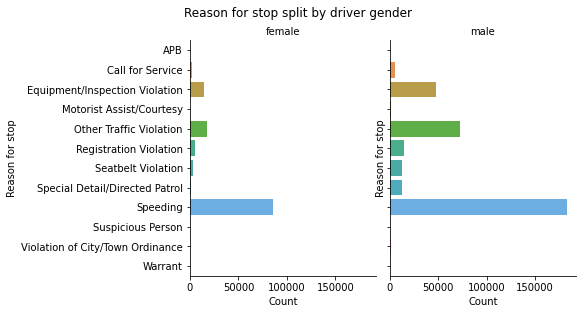

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set_palette("PuRd")

# Visualise total counts
g = sns.catplot(y="reason_for_stop", data=ri, kind="count", col="subject_sex", height=4)
g.fig.suptitle("Reason for stop split by driver gender",y=1.03)
g.set_titles("{col_name}")
g.set(xlabel="Count", ylabel="Reason for stop")
plt.show()
g.savefig("reason_stop_gender.png")

First thing we notice is that men get stoped more often than women. We would need to compare these number with the total number of man and women driving in order to draw any conclusion in this. It is also clear that by far, the most common reason for stop is speeding. Next step is to look at the percentages to see more clearly if reasons follow the same distributions for men and women.

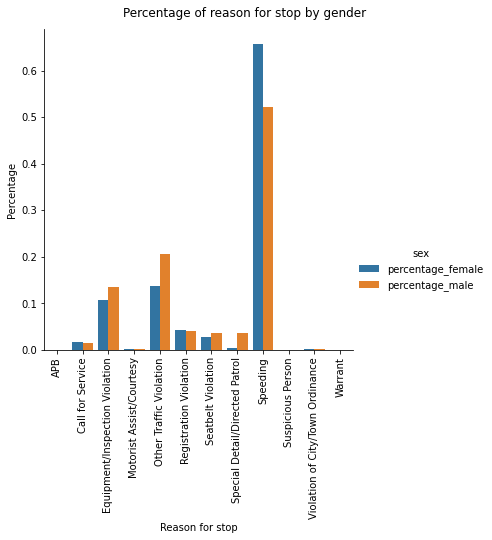

In [18]:
# Create a DataFrame of female drivers
female = ri[ri['subject_sex']=='female']

# Create a DataFrame of male drivers
male = ri[ri['subject_sex']=='male']

reason_female_df = female['reason_for_stop'].value_counts(normalize=True).rename_axis('reason_for_stop').reset_index(name='percentage')
reason_male_df = male['reason_for_stop'].value_counts(normalize=True).rename_axis('reason_for_stop').reset_index(name='percentage')

gender_reason = reason_female_df.merge(reason_male_df, suffixes=('_female','_male'), on='reason_for_stop')

# Create a latex table and save it in a file
gender_reason_table = gender_reason.to_latex(float_format="%.3f", index=False, header=["Reason for stop","Female","Male"])
with open("tables/gender_reason_table.txt", "w") as text_file:
    text_file.write(gender_reason_table)


gender_reason = pd.melt(gender_reason, id_vars="reason_for_stop", var_name="sex", value_name="percentage")

# Visualise the results
fig_reason = sns.catplot(x='reason_for_stop', y='percentage', hue='sex', data=gender_reason, kind='bar')
fig_reason.fig.suptitle("Percentage of reason for stop by gender",y=1.03)
fig_reason.set(xlabel="Reason for stop", ylabel="Percentage")
plt.xticks(rotation=90)
plt.show()
fig_reason.savefig("figures/reason_gender.png")


We see that, while in both cases speeding is the most common reason for stop, in the case of men, the difference with respect to the other reasons is not as big as in the case of women. 

#### Speeding outcome<a name="outcome"></a>

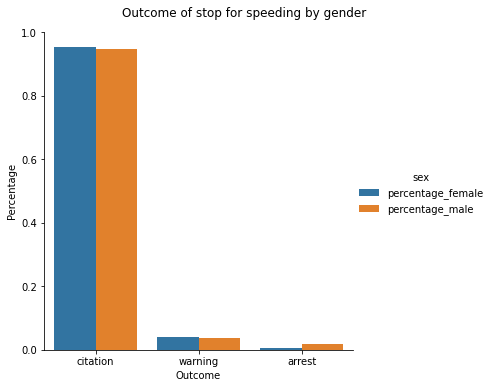

In [19]:
# Create a DataFrame of female drivers stopped for speeding
female_and_speeding = ri[(ri['subject_sex']=='female') & (ri['reason_for_stop']=='Speeding')]

# Create a DataFrame of male drivers stopped for speeding
male_and_speeding = ri[(ri['subject_sex']=='male') & (ri['reason_for_stop']=='Speeding')]

# Create a new dataframe merging both
female_and_speeding_df = female_and_speeding['outcome'].value_counts(normalize=True).rename_axis('outcome').reset_index(name='percentage')
male_and_speeding_df = male_and_speeding['outcome'].value_counts(normalize=True).rename_axis('outcome').reset_index(name='percentage')

gender_speeding = female_and_speeding_df.merge(male_and_speeding_df, suffixes=('_female','_male'), on='outcome')

# Create a latex table and save it in a file
speeding_outcome_gender_table = gender_speeding.to_latex(float_format="%.3f", index=False, header=["Outcome","Female","Male"])
with open("tables/speeding_outcome_gender_table.txt", "w") as text_file:
    text_file.write(speeding_outcome_gender_table)

gender_speeding = pd.melt(gender_speeding, id_vars="outcome", var_name="sex", value_name="percentage")

# Visualise the results
category_order = ["citation","warning","arrest"]
fig_outcome = sns.catplot(x='outcome', y='percentage', hue='sex', data=gender_speeding, kind='bar', order=category_order)
fig_outcome.fig.suptitle("Outcome of stop for speeding by gender",y=1.03)
fig_outcome.set(xlabel="Outcome", ylabel="Percentage")
plt.show()
fig_outcome.savefig("figures/speeding_outcome_gender.png")



More than 90% of the stops end up with a citation. We don't observe a difference by gender. 

#### Search rate<a name="search_rate"></a>

                                    female      male
reason_for_stop                                     
APB                               0.165138  0.255319
Call for Service                  0.042230  0.092419
Equipment/Inspection Violation    0.040245  0.070916
Motorist Assist/Courtesy          0.033133  0.089802
Other Traffic Violation           0.038021  0.059156
Registration Violation            0.054700  0.103589
Seatbelt Violation                0.017746  0.031705
Special Detail/Directed Patrol    0.018045  0.010249
Speeding                          0.007738  0.026630
Suspicious Person                 0.216216  0.305970
Violation of City/Town Ordinance  0.060185  0.073171
Warrant                           0.148148  0.311111


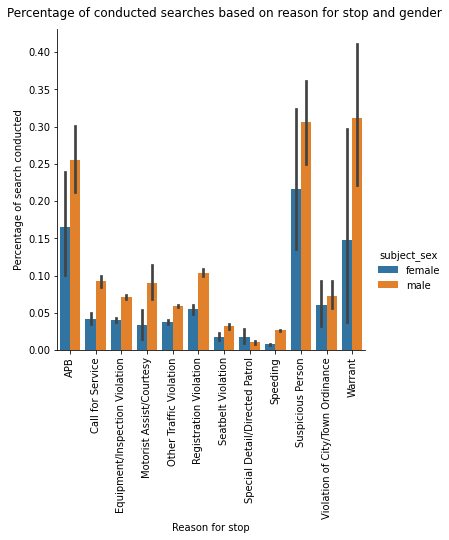

In [20]:
# Calculate the search rate for each combination of gender and violation
female_search = female.groupby('reason_for_stop').search_conducted.mean()
male_search = male.groupby('reason_for_stop').search_conducted.mean()

search_rate_gender_reason = pd.concat([female_search, male_search], axis=1, names=['female','male'])
search_rate_gender_reason.columns = ['female', 'male']
print(search_rate_gender_reason)

# Create a latex table and save it in a file
search_rate_gender_reason_table = search_rate_gender_reason.to_latex(float_format="%.3f", multicolumn=True)
with open("tables/search_rate_gender_reason_table.txt", "w") as text_file:
    text_file.write(search_rate_gender_reason_table)

fig_search = sns.catplot(x='reason_for_stop', y='search_conducted', hue='subject_sex', data=ri, kind='bar')
fig_search.fig.suptitle("Percentage of conducted searches based on reason for stop and gender",y=1.03)
fig_search.set(xlabel="Reason for stop", ylabel="Percentage of search conducted")
plt.xticks(rotation=90)
plt.show()
fig_search.savefig("figures/search_reason_gender.png")


### Studies over time<a name="time"></a>
#### Arrest per daytime<a name="arests_day"></a>

In [21]:
# Calculate the overall arrest rate
print("Mean arrest_made: ",ri['arrest_made'].mean())

# Calculate the hourly arrest rate
print(ri.groupby(ri.index.hour)['arrest_made'].mean())

# Save the hourly arrest rate
hourly_arrest_rate = ri.groupby(ri.index.hour)['arrest_made'].mean()

Mean arrest_made:  0.034545825287968575
datetime
0     0.052142
1     0.067121
2     0.061063
3     0.052604
4     0.053897
5     0.032657
6     0.012948
7     0.013829
8     0.019714
9     0.024698
10    0.025582
11    0.027078
12    0.031359
13    0.030248
14    0.031529
15    0.032124
16    0.033519
17    0.038989
18    0.039898
19    0.031366
20    0.039292
21    0.059956
22    0.043980
23    0.045084
Name: arrest_made, dtype: float64


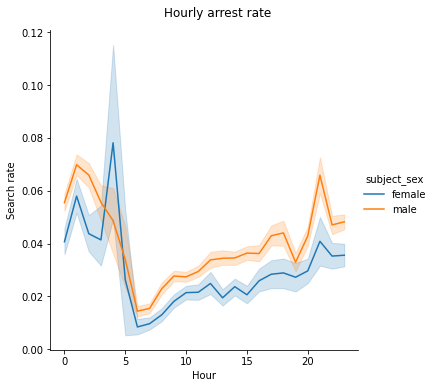

In [22]:
# Create a line plot of 'hourly_arrest_rate'
ri['hour'] = ri.index.hour
fig_arrest_day = sns.relplot(x='hour', y='arrest_made', data=ri, kind='line', hue='subject_sex')

fig_arrest_day.fig.suptitle("Hourly arrest rate",y=1.03)
fig_arrest_day.set(xlabel="Hour", ylabel="Search rate")
plt.show()
fig_arrest_day.savefig("figures/fig_arrest_day.png")


Most of the arrests are done at night-time, between ~9pm and 5am.

#### Search rate by year<a name="search_year"></a>

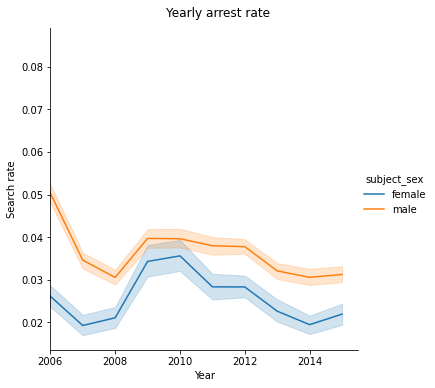

In [23]:
# Create a line plot of 'yearly_arrest_rate'
ri['year'] = ri.index.year
fig_arrest_year = sns.relplot(x='year', y='arrest_made', data=ri, kind='line', hue='subject_sex')
plt.xlim(2006, None)
fig_arrest_year.fig.suptitle("Yearly arrest rate",y=1.03)
fig_arrest_year.set(xlabel="Year", ylabel="Search rate")
plt.show()
fig_arrest_year.savefig("figures/fig_arrest_year.png")

#### Search rate by weekday<a name="search_weekday"></a>

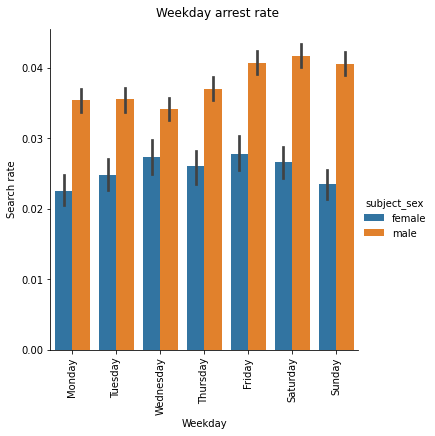

In [24]:
# Create a bar plot of arrest rate per weekday

ri['weekday'] = ri.index.weekday
ri['weekday'] = ri['weekday'].astype(int)

weekday_dict = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ri["weekday"].replace(weekday_dict, inplace=True)

days_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig_arrest_weekday = sns.catplot(x='weekday', y='arrest_made', data=ri, kind='bar', hue='subject_sex', order=days_order)
fig_arrest_weekday.fig.suptitle("Weekday arrest rate",y=1.03)
fig_arrest_weekday.set(xlabel="Weekday", ylabel="Search rate")
plt.xticks(rotation=90)
plt.show()
fig_arrest_weekday.savefig("figures/fig_arrest_weekday.png")

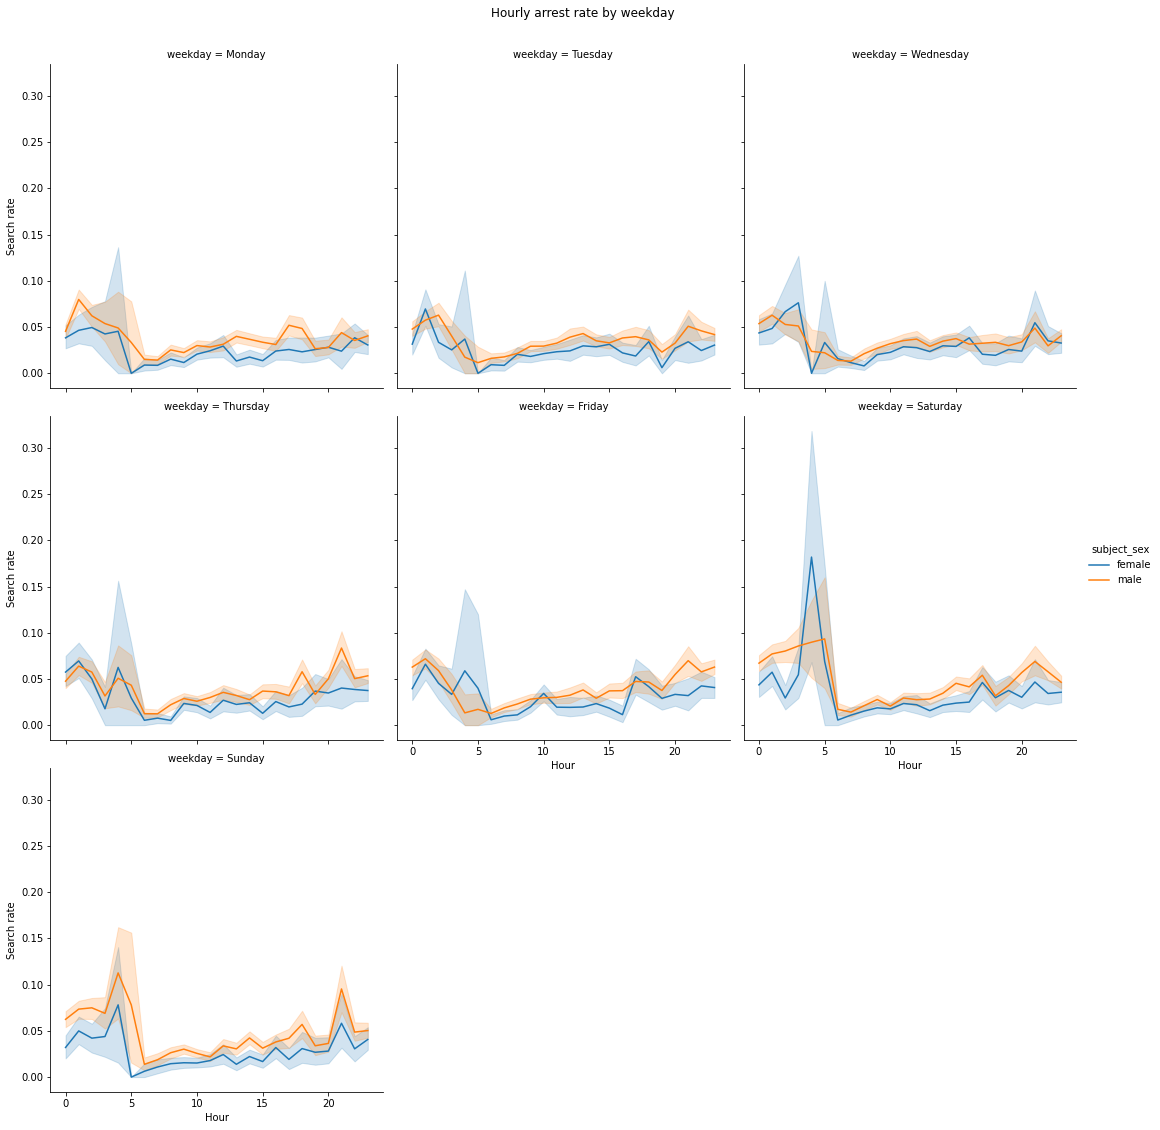

In [25]:
fig_arrest_day_hour = sns.relplot(x='hour', y='arrest_made', data=ri, kind='line', hue='subject_sex', col='weekday', col_wrap=3, col_order=days_order)
fig_arrest_day_hour.fig.suptitle("Hourly arrest rate by weekday",y=1.03)
fig_arrest_day_hour.set(xlabel="Hour", ylabel="Search rate")
plt.show()
fig_arrest_day_hour.savefig("figures/fig_arrest_day_hour.png")

#### Search versus arrest rates<a name="search_arrest_decrease"></a>

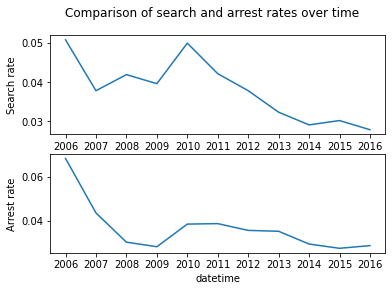

In [26]:
# Calculate and save the annual arrest rate
annual_search_rate = ri['search_conducted'].resample('A').mean()
annual_arrest_rate = ri['arrest_made'].resample('A').mean()

# Concatenate 'annual_search_rate' and 'annual_arrest_rate'
annual = pd.concat([annual_search_rate,annual_arrest_rate], axis='columns')

# Create the figures
fig_arrest_search, axes = plt.subplots(2, 1)
sns.lineplot(ax=axes[0], x=annual.index, y=annual.search_conducted)
sns.lineplot(ax=axes[1], x=annual.index, y=annual.arrest_made)
axes[0].set(ylabel="Search rate")
axes[1].set(ylabel="Arrest rate")
fig_arrest_search.suptitle("Comparison of search and arrest rates over time")
plt.show()
fig_arrest_search.savefig("figures/arrest_search.png")

### Reason for stop by district<a name="violations_district"></a>

In [27]:
# Create a frequency table of districts and violations
print(pd.crosstab(ri['zone'], ri['reason_for_stop']))

# Save the frequency table as 'all_zones'
all_zones = pd.crosstab(ri['zone'], ri['reason_for_stop'])


reason_for_stop  APB  Call for Service  Equipment/Inspection Violation  \
zone                                                                     
K1                32               282                            3788   
K2               101              1036                           11285   
K3               144              1230                           12959   
X1                 6               198                            1725   
X3                64              1328                           11520   
X4               138              3535                           19975   

reason_for_stop  Motorist Assist/Courtesy  Other Traffic Violation  \
zone                                                                 
K1                                     78                     7130   
K2                                    118                    16440   
K3                                    258                    16218   
X1                                     33                

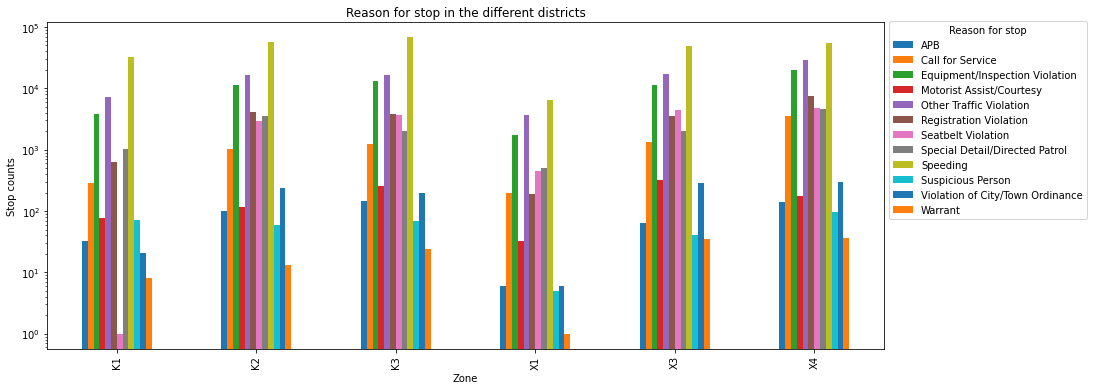

In [28]:
# Create a bar plot of 'all_zones'
fig_violations_district = all_zones.plot(kind='bar',logy=True, figsize=(15,6), title="Reason for stop in the different districts")
fig_violations_district.legend(title='Reason for stop', bbox_to_anchor=(1, 1.02), loc='upper left')
fig_violations_district.set_xlabel("Zone")
fig_violations_district.set_ylabel("Stop counts")

# Display the plot
plt.show()

# Save the plot
fig = fig_violations_district.get_figure()
fig.savefig("figures/fig_violations_district.png")

## Adding weather data<a name="weather"></a>

We now use weather data from a different dataset to understand if weather conditions affect the police stops. For that, we use weather data from the National Center for Environmental Information collected at the Rhode Island weather station, USW00014765 (https://www.ncei.noaa.gov/) and (https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_station/).

In [29]:
#Load the database into a dataframe
weather_file = 'data/USW00014765.csv'
wd = pd.read_csv(weather_file, usecols=[1,2,3], names=['date', 'metric','value'])

print(wd.head())

       date metric  value
0  19420801   TAVG    240
1  19420802   TAVG    222
2  19420803   TAVG    247
3  19420804   TAVG    207
4  19420805   TAVG    188


In [30]:
#Pivot the table so that each variable has its own column
weather=wd.pivot(index='date', columns='metric', values='value')
print(weather.head())

metric    ACMH  ACSH  AWND  FMTM  FRGT  PGTM  PRCP  PSUN  SNOW  SNWD  ...  \
date                                                                  ...   
19420801   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
19420802   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
19420803   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
19420804   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
19420805   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

metric    WT15  WT16  WT17  WT18  WT19  WT21  WT22  WV01  WV03  WV20  
date                                                                  
19420801   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
19420802   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
19420803   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
19420804   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
19420805   NaN   NaN   NaN   NaN  

In [31]:
# Subset to get the same time period as the police stops dataset
ws = weather.loc[20050101:20181231]

In [32]:
#Temperatures are given in tenths of degrees. 
#Change them to degrees.
def convert_tenths_to_celsius(tf):
    tf = tf/10.0
    return tf

ws[['TMIN','TAVG','TMAX']] = ws[['TMIN','TAVG','TMAX']].apply(convert_tenths_to_celsius)

/Users/laubana/Library/Python/3.8/lib/python/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


metric         TMIN         TAVG         TMAX
count   5113.000000  2313.000000  5113.000000
mean       6.480325    11.528534    16.359476
std        9.447401     9.731215    10.121332
min      -22.700000   -17.600000   -11.000000
25%       -1.000000     3.900000     8.300000
50%        6.700000    11.900000    16.700000
75%       14.400000    20.100000    25.000000
max       25.000000    29.900000    38.900000


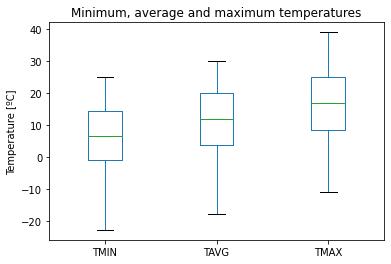

In [33]:
# Inspect the temperature columns 
print(ws[['TMIN','TAVG','TMAX']].describe())

# Create a box plot of the temperature columns
fig_temperatures_box = ws[['TMIN','TAVG','TMAX']].plot(kind='box', title="Minimum, average and maximum temperatures")
fig_temperatures_box.set_ylabel("Temperature [ºC]")

# Display the plot
plt.show()

# Save the plot
fig = fig_temperatures_box.get_figure()
fig.savefig("figures/fig_temperatures_box.png")

<ipython-input-34-d9341482935e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['TDIFF'] = ws['TMAX']-ws['TMIN']


count    5113.000000
mean        9.879151
std         3.509849
min         1.100000
25%         7.700000
50%        10.000000
75%        12.200000
max        23.900000
Name: TDIFF, dtype: float64


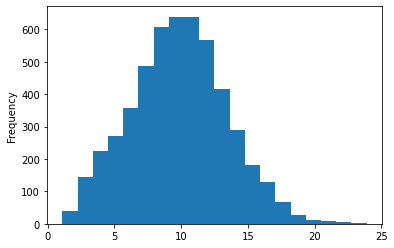

In [34]:
# Create a 'TDIFF' column that represents temperature difference
ws['TDIFF'] = ws['TMAX']-ws['TMIN']

# Describe the 'TDIFF' column
print(ws['TDIFF'].describe())

# Create a histogram with 20 bins to visualize 'TDIFF'
ws['TDIFF'].plot(kind='hist', bins=20)

# Display the plot
plt.show()

### Counting and rating bad weather conditions<a name="bad_weather"></a>

The weather DataFrame contains 20 columns that start with 'WT', each of which represents a bad weather condition. For example:

* WT05 indicates "Hail"
* WT11 indicates "High or damaging winds"
* WT17 indicates "Freezing rain"
For every row in the dataset, each WT column contains either a 1 (meaning the condition was present that day) or NaN (meaning the condition was not present).

We quantify "how bad" the weather was each day by counting the number of 1 values in each row.

<ipython-input-35-47384e7de2c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['bad_conditions'] = WT.sum(axis='columns')
<ipython-input-35-47384e7de2c0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['bad_conditions'] = ws.bad_conditions.fillna(0).astype('int')


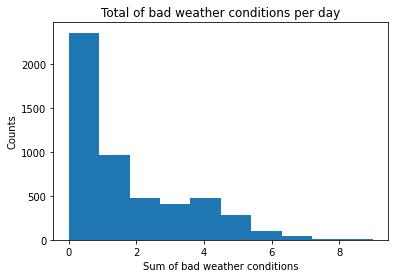

In [35]:
# Copy 'WT01' through 'WT22' to a new DataFrame
WT = ws.loc[:,'WT01':'WT22']

# Calculate the sum of each row in 'WT'
ws['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
ws['bad_conditions'] = ws.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
fig_bad_weather_conditions = ws['bad_conditions'].plot(kind='hist', title="Total of bad weather conditions per day")
fig_bad_weather_conditions.set_ylabel("Counts")
fig_bad_weather_conditions.set_xlabel("Sum of bad weather conditions")

# Display the plot
plt.show()

# Save the plot
fig = fig_bad_weather_conditions.get_figure()
fig.savefig("figures/fig_bad_weather_conditions.png")

The counting of bad weather conditions ranges from 0 to 9. We use this information to create a "bad weather rating" as follows:

* Convert 0 to 'good'
* Convert 1 through 4 to 'bad'
* Convert 5 through 9 to 'worse'

In [36]:
# Count the unique values in 'bad_conditions' and sort the index
print(ws.bad_conditions.value_counts().sort_index())

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad',4:'bad',5:'worse',6:'worse',7:'worse',8:'worse',9:'worse'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
ws['rating'] = ws.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(ws['rating'].value_counts())

0    2356
1     965
2     477
3     403
4     478
5     283
6     102
7      41
8       4
9       4
Name: bad_conditions, dtype: int64
good     2356
bad      2323
worse     434
Name: rating, dtype: int64


<ipython-input-36-e63b5b4697b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws['rating'] = ws.bad_conditions.map(mapping)


In [37]:
# Create a list of weather ratings in logical order
cats = ['good','bad','worse']

# Change the data type of 'rating' to category
cat_type = pd.Categorical(ws['rating'], categories=cats, ordered=True)

# Examine the head of 'rating'
print(ws['rating'].head())

date
20050101    bad
20050102    bad
20050103    bad
20050104    bad
20050105    bad
Name: rating, dtype: object


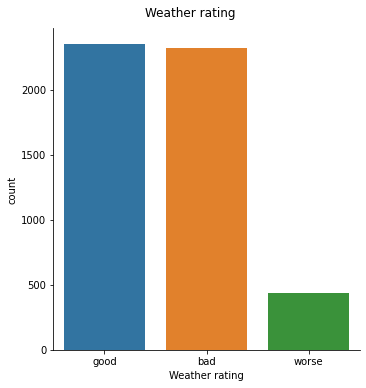

In [55]:
# Visualise the new rating
fig_weather_rating = sns.catplot(x='rating', data=ws, kind='count', order=['good','bad','worse'])
fig_weather_rating.fig.suptitle("Weather rating",y=1.03)
fig_weather_rating.set(xlabel="Weather rating")
fig_weather_rating.savefig("figures/weather_rating.png")

### Preparing the two dataframes to be merged<a name="prepare_merge"></a>

In [38]:
# Reset the index of 'ri' and 'ws'
ri.reset_index(inplace=True)
ws.reset_index(inplace=True)

# Examine the head of 'ri'
print(ri.head())

# Create a DataFrame from the 'DATE' and 'rating' columns
weather_rating = ws[['date','rating']]

# Examine the head of 'weather_rating'
print(weather_rating.head())

             datetime  raw_row_number        date zone subject_race  \
0 2005-11-22 11:15:00               1  2005-11-22   X3        white   
1 2005-10-01 12:20:00               2  2005-10-01   X3        white   
2 2005-10-01 12:30:00               3  2005-10-01   X3        white   
3 2005-10-01 12:50:00               4  2005-10-01   X3        white   
4 2005-10-01 13:10:00               5  2005-10-01   X3        white   

  subject_sex department_id  arrest_made  citation_issued  warning_issued  \
0        male           200        False             True           False   
1        male           200        False             True           False   
2      female           200        False             True           False   
3        male           200        False             True           False   
4      female           200        False             True           False   

   ... reason_for_stop  vehicle_make  vehicle_model raw_BasisForStop  \
0  ...        Speeding           NaN  

In [39]:
# Set the two date columns to the same format
ri['date'] = pd.to_datetime(ri['date'])
weather_rating['date'] = pd.to_datetime(weather_rating['date'], format='%Y%m%d', errors='ignore')

<ipython-input-39-acf58e21d741>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_rating['date'] = pd.to_datetime(weather_rating['date'], format='%Y%m%d', errors='ignore')


In [40]:
print(weather_rating.date)

0      2005-01-01
1      2005-01-02
2      2005-01-03
3      2005-01-04
4      2005-01-05
          ...    
5108   2018-12-27
5109   2018-12-28
5110   2018-12-29
5111   2018-12-30
5112   2018-12-31
Name: date, Length: 5113, dtype: datetime64[ns]


In [41]:
# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, on='date', how='left')

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('date', inplace=True)

In [42]:
print(ri_weather.head())

                      datetime  raw_row_number zone subject_race subject_sex  \
date                                                                           
2005-11-22 2005-11-22 11:15:00               1   X3        white        male   
2005-10-01 2005-10-01 12:20:00               2   X3        white        male   
2005-10-01 2005-10-01 12:30:00               3   X3        white      female   
2005-10-01 2005-10-01 12:50:00               4   X3        white        male   
2005-10-01 2005-10-01 13:10:00               5   X3        white      female   

           department_id  arrest_made  citation_issued  warning_issued  \
date                                                                     
2005-11-22           200        False             True           False   
2005-10-01           200        False             True           False   
2005-10-01           200        False             True           False   
2005-10-01           200        False             True           Fals

### Comparing arrest rates by weather rating<a name="arrest_rating"></a>
Do police officers arrest drivers more often when the weather is bad? 

* First, we calculate the overall arrest rate.
* Then, we calculate the arrest rate for each of the weather ratings previously assigned.
* Finally, we add violation type as a second factor in the analysis, to see if that accounts for any differences in the arrest rate.


In [43]:
# Calculate the overall arrest rate
print(ri_weather['arrest_made'].mean())

# Calculate the arrest rate for each 'rating'
print(ri_weather.groupby('rating')['arrest_made'].mean())

# Calculate the arrest rate for each 'violation' and 'rating'
print(ri_weather.groupby(['reason_for_stop','rating'])['arrest_made'].mean())

0.034545825287968575
rating
bad      0.035198
good     0.033002
worse    0.039357
Name: arrest_made, dtype: float64
reason_for_stop                   rating
APB                               bad       0.284314
                                  good      0.239496
                                  worse     0.372093
Call for Service                  bad       0.187269
                                  good      0.175385
                                  worse     0.177381
Equipment/Inspection Violation    bad       0.059704
                                  good      0.056480
                                  worse     0.094373
Motorist Assist/Courtesy          bad       0.103371
                                  good      0.116009
                                  worse     0.070175
Other Traffic Violation           bad       0.057973
                                  good      0.055618
                                  worse     0.062233
Registration Violation            bad       0.09

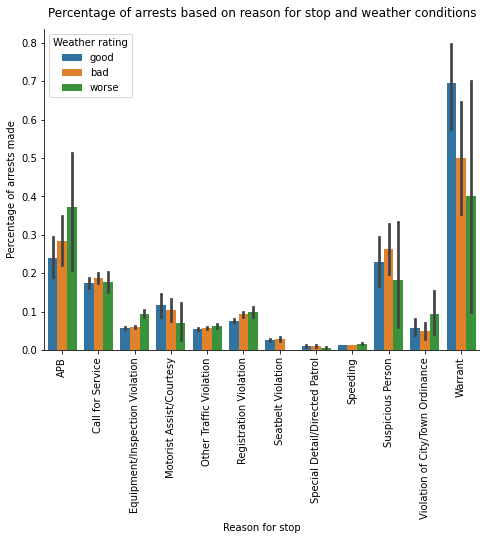

In [44]:
# Visualise this result
fig_arrest_reason_weather = sns.catplot(x='reason_for_stop', y='arrest_made', hue='rating', data=ri_weather, kind='bar', hue_order=['good','bad','worse'], aspect=1.4, legend=False)
fig_arrest_reason_weather.fig.suptitle("Percentage of arrests based on reason for stop and weather conditions",y=1.03)
fig_arrest_reason_weather.set(xlabel="Reason for stop", ylabel="Percentage of arrests made")
plt.xticks(rotation=90)
plt.legend(title='Weather rating')
plt.show()
fig_arrest_reason_weather.savefig("figures/fig_arrest_reason_weather.png")